## SINDy Algorithm

SINDy tries to find the dynamical system $f$ that suits the data $\mathrm{\dot X} = f(\mathrm{X})$. This function approximation problem is formulated as linear regression $\mathrm{\dot X} = \Theta(\mathrm{X})  \Xi$, with coefficients $\Xi$ and a library of regression terms $\Theta(X)$. The algorithm proceeds in three steps:

1. Generate data $X$ from a dynamical system and compute derivatives $\dot X$.
2. Set up library of candidate terms $\Theta(X)$ as functions on $X$.
3. Sparsely regress the coefficients $\Xi$, that best describe the data.

1. SINDy assumes a time-series of $n$-dimensional data points $\mathbf{x}=(x_1, \ldots x_n)$ measured at $m$ time steps $t_1, \ldots,  t_m$, we define the data matrix $X$ as and derivatives matrix $\dot X$: 

$$X = \begin{bmatrix}
x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
\end{bmatrix},
\qquad
\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
\vdots & \vdots & & \vdots \\
\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
\end{bmatrix}.$$

2. Next, we define the library matrix $\Theta(X)$, the columns of which are a set of basis functions $\{\theta_l\}_{l=1,\ldots, L}$ applied to the data:

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

Simple examples are e.g. a basis of polynomials $x_1, x_2, x_1^2, x_2^2, x_1 x_2, x_1^3 \ldots$, such as in the *Taylor expansion*, or trigonometric functions $\sin(x_1), \cos (x_1), \sin(2 x_1), \ldots $, such as in a *Fourier expansion*. But, depending on the problem more complex basis may be appropriate, e.g. Bessel functions.

3. Lastly, we employ a sparse linear regression algorithm (such as e.g. LASSO) to find the coefficients $\Xi$,
$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}, 
$$

such that 

$$\mathrm{\dot X} = \Theta(\mathrm{X})  \Xi.$$

## Example: Linear Dynamical System

Suppose we measure a particle trajectory that is governed by the following dynamical system:

$$
	\frac{d}{dt} \begin{pmatrix} x \\ y \end{pmatrix}
	= \begin{pmatrix} -2x \\ y \end{pmatrix}
	= \begin{pmatrix} -2 & 0 \\ 0 & 1 \end{pmatrix}
	\begin{pmatrix} x \\ y \end{pmatrix}
$$

With the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, we construct the data matrix $X$:

In [2]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

In [3]:
t = np.linspace(0,1,100)
x = 3*np.exp(-2*t)
y = 0.5 * np.exp(t)
X = np.stack((x,y),axis=-1)

In [4]:
model = ps.SINDy(differentiation_method=ps.FiniteDifference(order=2),
                 feature_library=ps.FourierLibrary(),
                 optimizer=ps.STLSQ(threshold=0.2),
                 feature_names=["x","y"])

In [5]:
model.fit(X,t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x0000026D55793410>,
      feature_names=['x', 'y'], optimizer=STLSQ(threshold=0.2))

In [6]:
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)


In [7]:
def plot_simulation(model, x0, y0):
    t_test = np.linspace(0, 1, 100)
    x_test = x0 * np.exp(-2 * t_test)
    y_test = y0 * np.exp(t_test)
    
    sim = model.simulate([x0, y0], t=t_test)

    plt.figure(figsize=(6, 4))
    plt.plot(x_test, y_test, label="Ground truth", linewidth=4)
    plt.plot(sim[:, 0], sim[:, 1], "--", label="SINDy estimate", linewidth=3)
    plt.plot(x0, y0, "ko", label="Initial condition", markersize=8)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

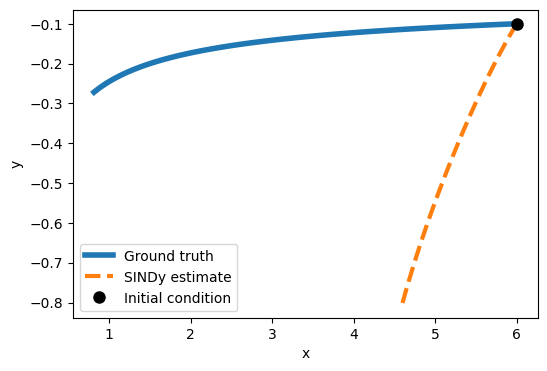

In [8]:
x0 = 6
y0 = -0.1
plot_simulation(model, x0,y0)

In [9]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=1),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=1), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [10]:
model_1.print()

(x)' = -2.000 x
(y)' = 1.000 y


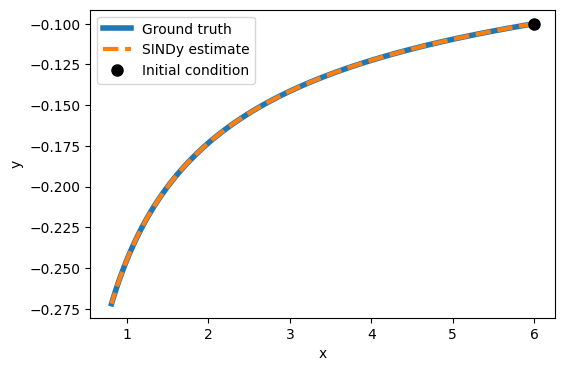

In [11]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

In [12]:
model_1 = ps.SINDy(
    differentiation_method=ps.FiniteDifference(order=2),
    feature_library=ps.PolynomialLibrary(degree=4),
    optimizer=ps.STLSQ(threshold=0.2),
    feature_names=["x", "y"]
)
model_1.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [13]:
model_1.print()

(x)' = -1.280 x + -0.960 x^2 y^2
(y)' = 1.000 y


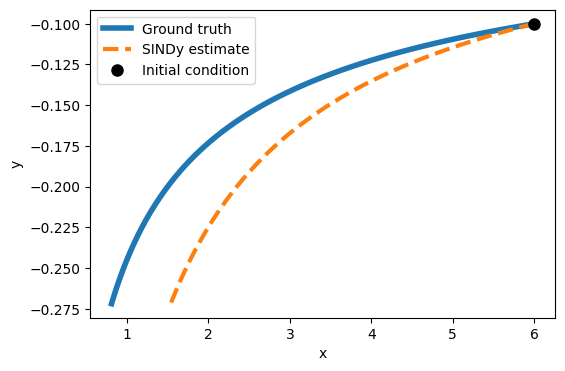

In [14]:
x0 = 6
y0 = -0.1
plot_simulation(model_1, x0,y0)

## Example: Lorenz attractor

In [15]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [16]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state  
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 40.0, dt)

x_train = odeint(f, state0, time_steps)

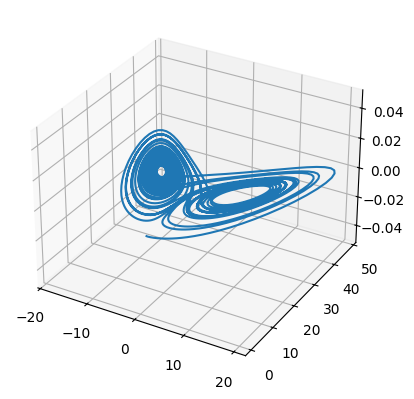

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_train[:, 0], x_train[:, 2])

plt.show()

In [ ]:
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=2),
)

model.fit(x_train, t=dt)

In [ ]:
model.print()

(x0)' = -9.977 x0 + 9.977 x1
(x1)' = 27.808 x0 + -0.963 x1 + -0.995 x0 x2
(x2)' = -2.659 x2 + 0.997 x0 x1


In [ ]:
x_sim = model.simulate(x_train[0], time_steps)

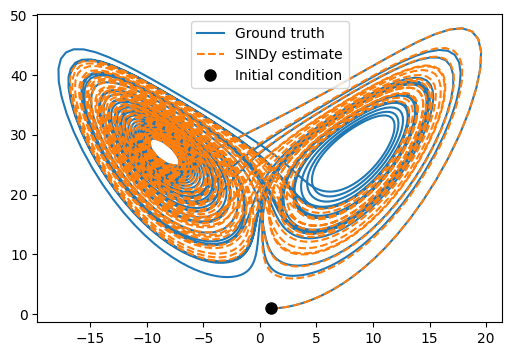

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:, 0], x_train[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

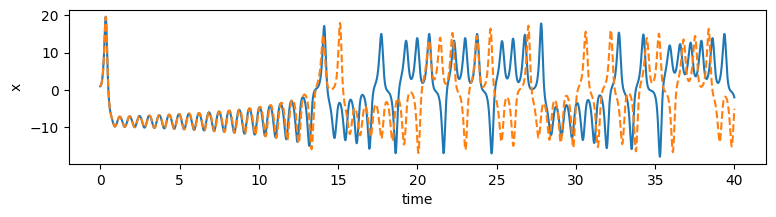

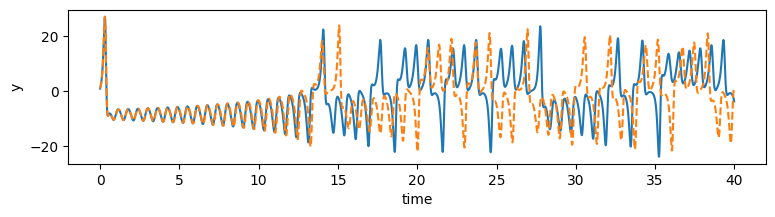

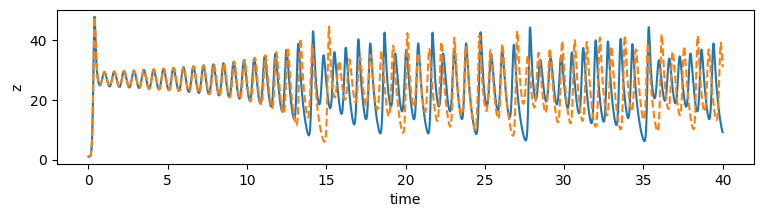

In [ ]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)

plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')